In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

from skimage.io import imread, imsave
from skimage.measure import find_contours
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.morphology import binary_erosion
from skimage.draw import polygon
from skimage.transform import warp_polar
from skimage.transform import warp, EuclideanTransform

from scipy.ndimage import distance_transform_edt
from scipy.optimize import fmin, least_squares
from scipy.signal import savgol_filter
from scipy.io import savemat

In [3]:
path = '/media/guillermo/Expansion/Thesis GY' 

In [4]:
path = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/'
file = '2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif'
nt = 216

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

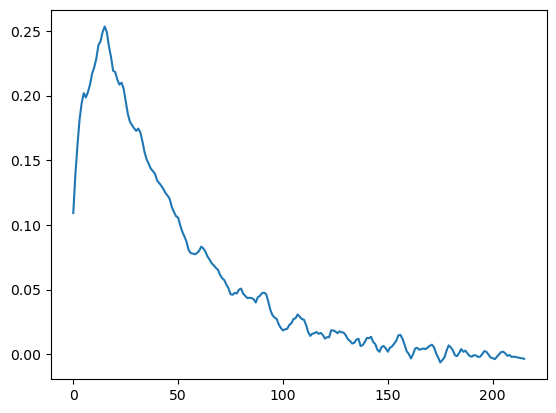

In [5]:
exprate = np.load('/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos6/expansion_rate.npy')
edt = np.load('/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos6/edt_reg.npy')

r0 = 49.30114892335611
def fmin_func(t):
    def func(x):
        mu0 = x
        resid = []
        #D = r0 * (1 - np.exp(-rmax[t] / r0))
        #mu0 =  2 * vfront[t] / D
        gr = mu0 * np.exp(-edt[t,:,:]/r0)
        gr[edt[t,:,:]==0] = np.nan
        meangr = np.nanmean(gr, axis=(0,1))
        err = meangr - exprate[t]
        return err*err
    return func

mu0 = np.zeros((nt,))
for t in range(nt):
    func = fmin_func(t)
    res = fmin(func, x0=0.3)
    #res = least_squares(fmin_func(), x0=30, bounds=[0,rmax[50]])
    mu0[t] = res

#np.save('results/mu0_fit.npy', mu0)
plt.plot(mu0)
#plt.savefig('graphs/mu0_graph.png')
plt.show()

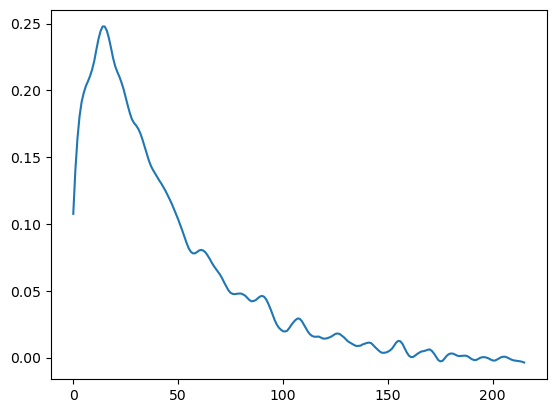

In [7]:
plt.plot(savgol_filter(mu0, 11, 3))

### Compute velocity using info tracking

In [9]:
import infotracking
from infotracking import Ensemble, infotheory
import numpy as np
import skimage
from skimage.io import imread,imsave
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
import os


In [ ]:

# Parameters -----------------------------------
path = 'velocity_data'

startframe = 0
step = 1
nframes = 120
nt = nframes-1

windowsize = 64
windowspacing = 32
window_px0 = 0
window_py0 = 0

maxvel = 19

#------------------------------------------------
# Run analysis
#im = imread('../10x_1.5x_-5_pAAA_MG_1_MMStack_Pos9.ome.tif')
# im = imread('C4-Pos12.25-40.tif')
#im = imread('../C4-Fused_12_13_14_15_1024.tif')
#im = imread('../10x_1.5x_-5_pAAA_MG_1_MMStack_Pos8.ome.tif')
im = imread('10x_1.0x_pLPT20_DHL_1_MMStack_Pos0.ome.tif')
im = im[:,:,:,0]

#mask = imread('../C2-10x_1.5x_-5_pAAA_MG_1_MMStack_Pos9.ome.mask.tif')
#mask = imread('C4-Pos12.25-40.mask.tif')
#mask = imread('../C4-Fused_12_13_14_15_1024.contour.mask.tif')
#mask = imread('../C2-10x_1.5x_-5_pAAA_MG_1_MMStack_Pos8_phase.contour.mask.ome.tif')
#mask = imread('../C2-10x_1.5x_-5_pAAA_MG_1_MMStack_Pos9.contour.mask.ome.tif')
mask = imread('contour_masks/120_frames/10x_1.0x_pLPT20_DHL_1_MMStack_Pos0.contour.mask.tif')

#init_vel = np.load('vinit.npy')
init_vel = np.zeros(mask.shape + (2,))

#mask = np.zeros(im.shape[:3])
#x,y = np.meshgrid(np.arange(1024), np.arange(632))
#cx,cy = 320,500
#r = np.sqrt((x-cy)**2 + (y-cx)**2)
#m = r<300
#for frame in range(im.shape[0]):
#    mask[frame,:,:] = m

mask = mask / mask.max() # Make sure 0-1

im = im[startframe:startframe+(nframes * step):step,:,:]
mask = mask[startframe:startframe+(nframes * step):step,:,:]
#mask = mask[startframe-15:startframe-15+(nframes * step):step,:,:]

print("Image dimensions ",im.shape)
eg = Ensemble.EnsembleGrid(im, mask, init_vel, mask_threshold=0.5)

eg.initialise_ensembles(windowsize,windowsize, \
                        windowspacing,windowspacing, \
                        window_px0,window_py0)
print("Grid dimensions ", eg.gx,eg.gy)

eg.compute_motion(nt,maxvel,maxvel,velstd=21,dt=1)


# Generate some output
print("Saving quiver plots...")
eg.save_quivers(path, 'quiver_image_%04d.png', 'quiver_plain_%04d.png', normed=False)
#print("Saving trajectory plots...")
#eg.save_paths(path, 'path_image_%04d.png', 'path_plain_%04d.png')
print("Saving data files...")
eg.save_data(path)

